# YLearn Case Study - Bank Customer Transaction Amount

## Content

1. Summary
1. Dataset
1. Causal Effect with Defined Treatment
    1. Statistics of Card_Category
    1. Learn Why with `treatment='Card_Category'`
    1. Estimate causal effect
    1. Counterfactual inference
    1. Policy interpreter
    1. Effect comparison
    1. Conclusion
1. Causal Effect with Discovery
    1. Learn Why with `treatment=None`
    1. Estimate causal effect on train_data
    1. Estimate causal effect on test_data
    1. Conclusion

## 1. Summary

This notebook utilizes a typical bank customer dataset to demonstrate the usage of all-in-one API `Why` of YLearn. `Why` covers the full processing pipeline of causal learning, including causal discovery, causal effect identification, causal effect estimation, counterfactual inference, and policy learning. 

One should firstly create an instance of `Why` which needs to be trained by calling its method `fit()`. Both customized setting (with a defined treatment) and default setting (to discover treatments by the algorithm itself) are introduced. The following utilities, such as `plot_causal_graph()`, `causal_effect()` and `whatif()` are performed to analyze various counterfactual scenarios. Another key method `policy_interpreter()` provides a customized solution to optimize the output. 


## 2. Dataset

The dataset used in this notebook is a subset of Kaggle [BankChurners](https://www.kaggle.com/datasets/syviaw/bankchurners) dataset. It’s intended to predict churning customers. However, we use it to analyze the causes of total transaction amount and provide customized strategies to maximize the transaction amount. The dataset contains the information of around 10,000 customers with nearly 20 continuous and categorical variables that represent user's characteristics. We manually select 10 variables to analyze their causal relations and causal effect, which are shown below:

* Customer general features: Customer_Age, Gender, Dependent_count, Education_Level, Marital_Status,  Income_Category
* Customer credit card features: Months_on_book, Card_Category, Credit_Limit
* Customer transaction amount: Total_Trans_Amt

The `Total_Trans_Amt` is the outcome in this notebook.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot  as plt

from sklearn.model_selection import train_test_split
from ylearn import Why

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/BankChurners.csv.zip')
cols = ['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 
        'Months_on_book', 'Card_Category', 'Credit_Limit',  
        'Total_Trans_Amt' 
     ]
data = df[cols]
outcome = 'Total_Trans_Amt'

data 

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Months_on_book,Card_Category,Credit_Limit,Total_Trans_Amt
0,45,M,3,High School,Married,$60K - $80K,39,Blue,12691.0,1144
1,49,F,5,Graduate,Single,Less than $40K,44,Blue,8256.0,1291
2,51,M,3,Graduate,Married,$80K - $120K,36,Blue,3418.0,1887
3,40,F,4,High School,Unknown,Less than $40K,34,Blue,3313.0,1171
4,40,M,3,Uneducated,Married,$60K - $80K,21,Blue,4716.0,816
...,...,...,...,...,...,...,...,...,...,...
10122,50,M,2,Graduate,Single,$40K - $60K,40,Blue,4003.0,15476
10123,41,M,2,Unknown,Divorced,$40K - $60K,25,Blue,4277.0,8764
10124,44,F,1,High School,Married,Less than $40K,36,Blue,5409.0,10291
10125,30,M,2,Graduate,Unknown,$40K - $60K,36,Blue,5281.0,8395


In [4]:
train_data,test_data=train_test_split(data,test_size=0.3,random_state=123)

print('train_data:',train_data.shape)
print('test_data: ',test_data.shape)

train_data: (7088, 10)
test_data:  (3039, 10)


## 3. Causal Effect with Defined Treatment


### A. Statistics of Card_Category

Among the three credit card features, `Card_Category` is a categorical and reasonable variable as treatment. An overview of card categories and corresponding average transaction amount is displayed below.

Total_Trans_Amt             
                         mean   min    max
Card_Category                             
Blue              4231.481184   510  17995
Silver            6743.212121   691  17628
Gold              7516.448276   966  16328
Platinum          8047.133333  1156  16712

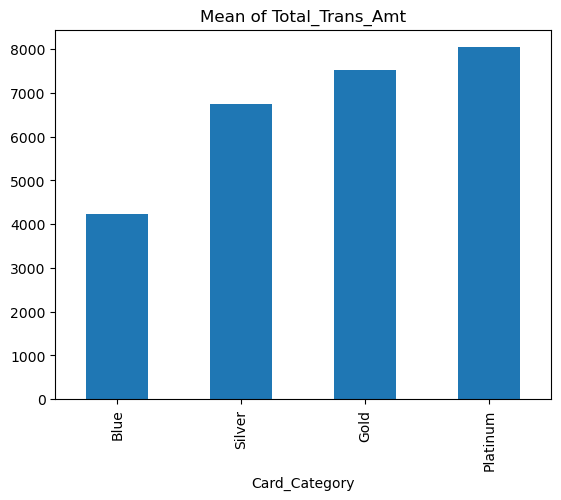

In [5]:
card_stat=train_data[['Card_Category','Total_Trans_Amt']].groupby('Card_Category').agg(['mean','min','max',]).sort_values(by=('Total_Trans_Amt','mean'))

card_stat[('Total_Trans_Amt','mean')].plot(kind='bar', title='Mean of Total_Trans_Amt')
card_stat

### B. Learn Why with `treatment='Card_Category'`

Firstly, create an instance of `Why`. Then train the model with `fit()` method, which defines `treatment=’Card_Category’.` The printed logs show the information of identified results and used eatimator. To visualize the causal relations, use `plot_causal_graph()` to obtain the causal graph.

In [6]:
why=Why()
why.fit(train_data,outcome,treatment='Card_Category')

08-25 18:54:49 I ylearn.a._why.py 245 - infer outcome as regression
08-25 18:54:49 I ylearn.a._why.py 256 - identify treatment, adjustment, covariate and instrument
08-25 18:54:49 I ylearn.a._why.py 394 - infer discrete_treatment=True
08-25 18:54:49 I ylearn.a._why.py 409 - identified adjustment: None
08-25 18:54:49 I ylearn.a._why.py 410 - identified covariate: ['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Months_on_book', 'Credit_Limit']
08-25 18:54:49 I ylearn.a._why.py 411 - identified instrument: None
08-25 18:54:49 I ylearn.a._why.py 265 - encode treatment ...
08-25 18:54:49 I ylearn.a._why.py 275 - preprocess data ...
08-25 18:54:49 I ylearn.a._why.py 293 - fit estimator for Card_Category with PermutedTLearner(model=GradientBoostingRegressor(max_depth=100), random_state=2022, kwargs=None)


Why(discrete_outcome=False, discrete_treatment=True)

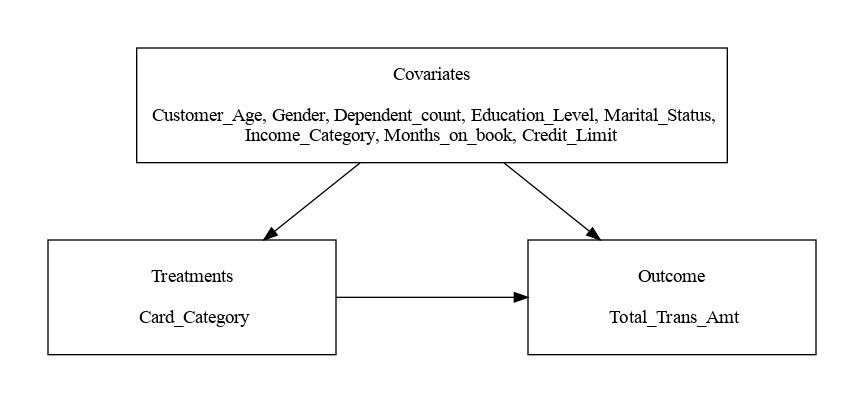

In [7]:
why.plot_causal_graph()

### C. Estimate causal effect

There are four types of card categoties: Blue, Sliver, Gold and Platinum. Taking Blue as control variable and the rest three as treatment variables, method `causal_effect()` outputs three causal effect estimations.  From the results, we find that card upgrade will increase the personal transaction amount. Gold card has the strongest effect.

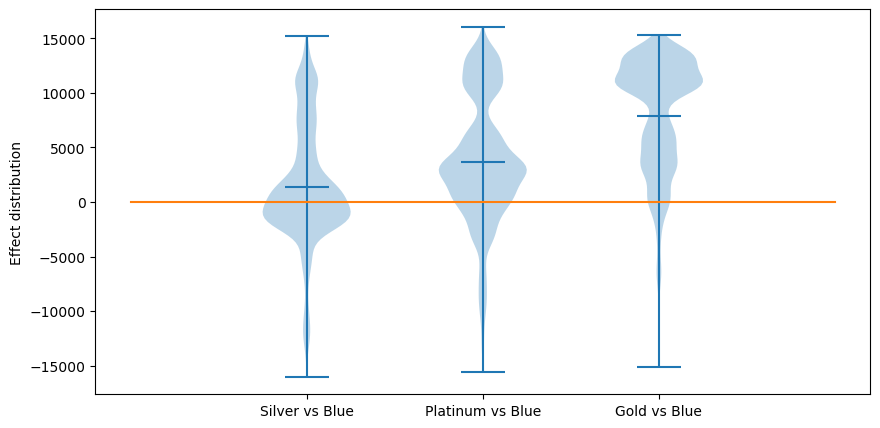

,mean,min,max,std
Silver vs Blue,1389.101262,-16030.507479,15200.662955,5474.555212
Platinum vs Blue,3698.362357,-15575.484931,16067.674561,5733.207134
Gold vs Blue,7879.761014,-15134.51074,15304.622191,5427.989114


In [8]:
effect=why.causal_effect(control='Blue',return_detail=True)
effect=effect.loc['Card_Category'].sort_values(by='mean')
details=effect.pop('detail')

plt.figure(figsize=(10, 5))
plt.violinplot(details.tolist(), showmeans=True)
plt.ylabel('Effect distribution')
plt.xticks(range(1,len(effect)+1), details.index.tolist())
plt.plot( [0, ]*(len(effect)+2) )
plt.show()

effect

### D. Counterfactual inference

As decision makers, they would like to know the estimated increment if upgrading customers' card category. `whatif()` provides the solution to do counterfactual inference.   

* Upgrade all **Blue** cards to **Sliver**

Selected customers: 6590
Mean Total_Trans_Amt with Blue card:	4231.481
Mean Total_Trans_Amt if Silver card:	5651.153


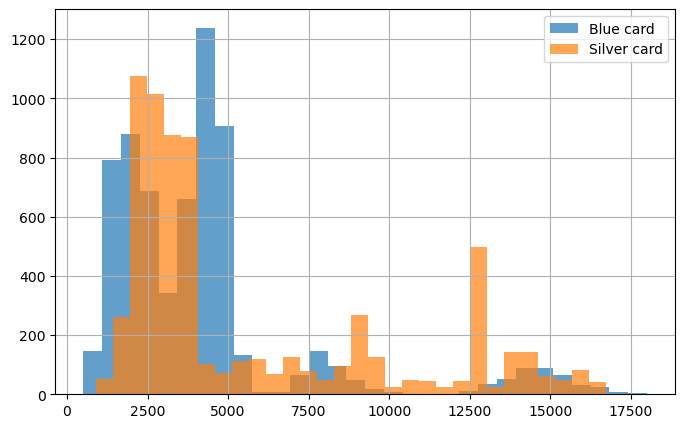

In [9]:
whatif_data= train_data[lambda df: df['Card_Category']=='Blue' ]
out_orig=whatif_data[outcome]

value_sliver=whatif_data['Card_Category'].map(lambda _:'Silver')
out_silver=why.whatif(whatif_data,value_sliver,treatment='Card_Category')

print('Selected customers:', len(whatif_data))
print(f'Mean {outcome} with Blue card:\t{out_orig.mean():.3f}' )
print(f'Mean {outcome} if Silver card:\t{out_silver.mean():.3f}' )

plt.figure(figsize=(8, 5), )
out_orig.hist(label='Blue card',bins=30,alpha=0.7)
out_silver.hist(label='Silver card',bins=30,alpha=0.7)
plt.legend()

* Upgrade all **Blue** cards to **Gold**

Selected customers: 6590
Mean Total_Trans_Amt with Blue card:	4231.481
Mean Total_Trans_Amt if Gold card:	12477.160


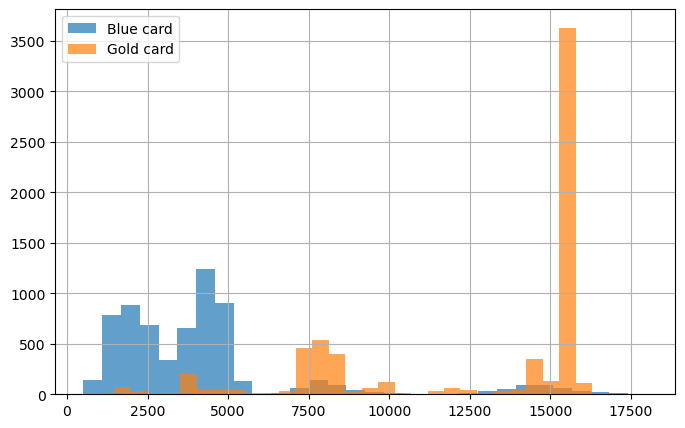

In [10]:
whatif_data= train_data[lambda df: df['Card_Category']=='Blue' ]
out_orig=whatif_data[outcome]

value_gold=whatif_data['Card_Category'].map(lambda _:'Gold')
out_gold=why.whatif(whatif_data,value_gold,treatment='Card_Category')


print('Selected customers:', len(whatif_data))
print(f'Mean {outcome} with Blue card:\t{out_orig.mean():.3f}' )
print(f'Mean {outcome} if Gold card:\t{out_gold.mean():.3f}' )

plt.figure(figsize=(8, 5), )
out_orig.hist(label='Blue card',bins=30,alpha=0.7)
out_gold.hist(label='Gold card',bins=30,alpha=0.7)
plt.legend()

* Upgrade all **Blue** cards to **Platinum**

Selected customers: 6590
Mean Total_Trans_Amt with Blue card:	4231.481
Mean Total_Trans_Amt if Platinum card:	8044.294


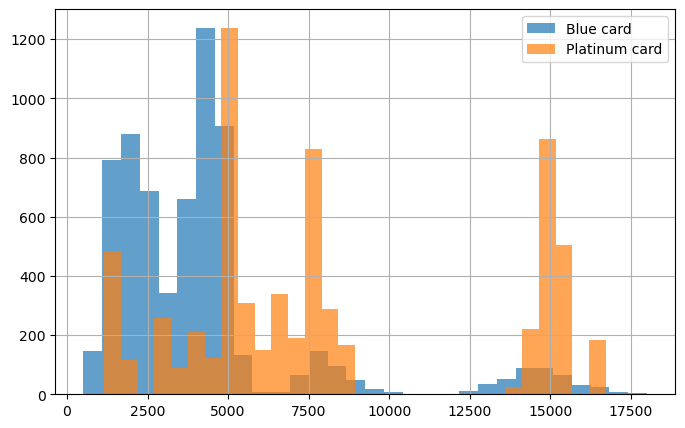

In [11]:
whatif_data= train_data[lambda df: df['Card_Category']=='Blue' ]
out_orig=whatif_data[outcome]

value_platinum=whatif_data['Card_Category'].map(lambda _:'Platinum')
out_platinum=why.whatif(whatif_data,value_platinum,treatment='Card_Category')


print('Selected customers:', len(whatif_data))
print(f'Mean {outcome} with Blue card:\t{out_orig.mean():.3f}' )
print(f'Mean {outcome} if Platinum card:\t{out_platinum.mean():.3f}' )

plt.figure(figsize=(8, 5), )
out_orig.hist(label='Blue card',bins=30,alpha=0.7)
out_platinum.hist(label='Platinum card',bins=30,alpha=0.7)
plt.legend()

By upgrading all Blue cards to Sliver, Gold and Platinum cards, the estimations of mean Total_Trans_Amt increase from 4231 to 5651, 12477 and 8044 respectively. It's a promising improvement. However, we may wonder if upgrading all Blue to Gold is the optimized solution. 

### E. Policy interpreter

YLearn also provides `policy_interpreter()` method to search the optimized solution.

08-25 18:54:58 I ylearn.p.policy_model.py 454 - Start building the policy tree with criterion PRegCriteria
08-25 18:54:58 I ylearn.p.policy_model.py 470 - Building the policy tree with splitter BestSplitter
08-25 18:54:58 I ylearn.p.policy_model.py 500 - Building the policy tree with builder DepthFirstTreeBuilder


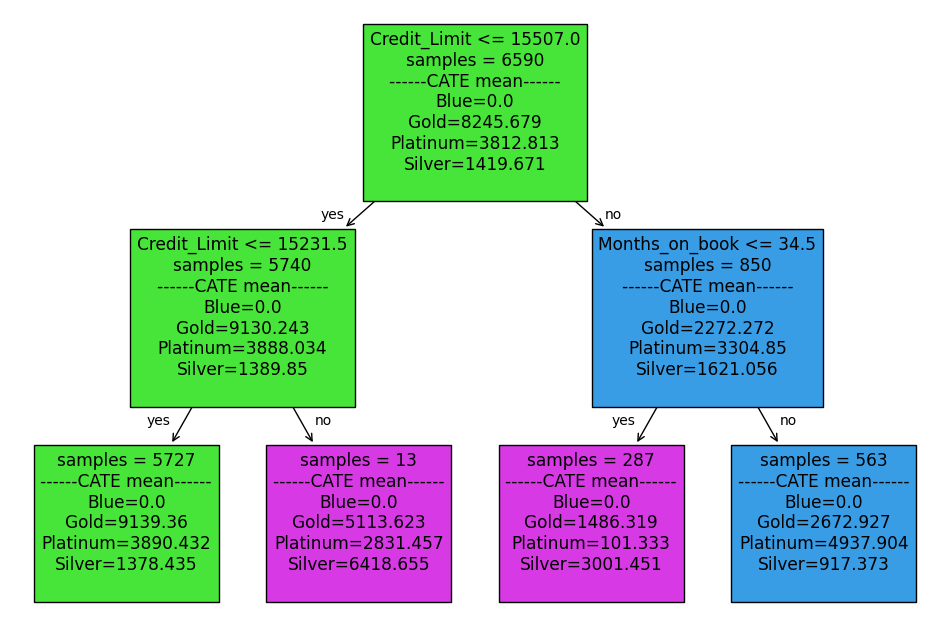

In [12]:
pi=why.policy_interpreter(whatif_data,  max_depth=2)

plt.figure(figsize=(12, 8), )
pi.plot()

The tree intepreter is split into four nodes based on Credit_Limit and Month_on_book. The value array indicates the causal effects of the control variable(Blue vs Blue) and three treatments(Gold vs Blue, Platinum vs Blue, Silver vs Blue). The higher value means the better performance. Looking at the first node, the policy tree recommends to upgrade Blue cards to Gold for customers with 'Credit_limit<=15231.5'. 

* Upgrade credit card with causal policy

Selected customers: 6590
Mean of Total_Trans_Amt with Blue card:	4231.481
Mean of Total_Trans_Amt if apply policy:	12739.222


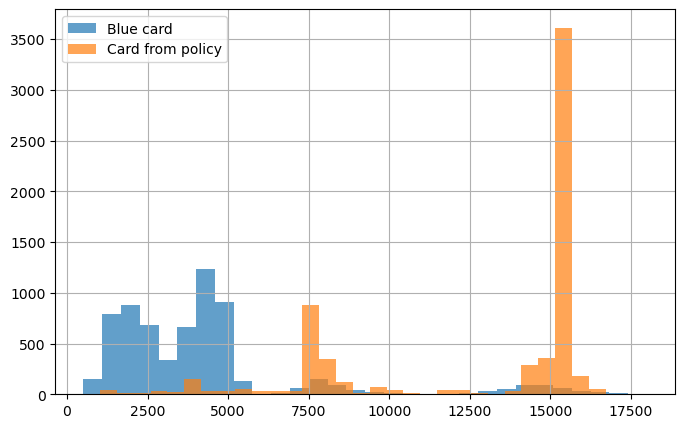

In [13]:
whatif_data= train_data[lambda df: df['Card_Category']=='Blue' ]
out_orig=whatif_data[outcome]

value_from_policy=pi.decide(whatif_data)
out_from_policy=why.whatif(whatif_data,value_from_policy,treatment='Card_Category')


print('Selected customers:', len(whatif_data))
print(f'Mean of {outcome} with Blue card:\t{out_orig.mean():.3f}' )
print(f'Mean of {outcome} if apply policy:\t{out_from_policy.mean():.3f}' )

plt.figure(figsize=(8, 5), )
out_orig.hist(label='Blue card',bins=30,alpha=0.7)
out_from_policy.hist(label='Card from policy',bins=30,alpha=0.7)
plt.legend()

### F. Effect comparison

,Mean of Total_Trans_Amt
Blue to Silver,5651.152584
Blue to Gold,12477.160069
Blue to Platinum,8044.293858
Card from Policy,12739.222379


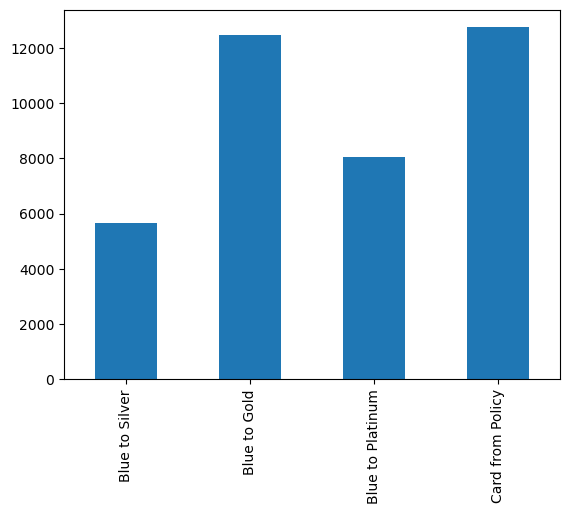

In [14]:
whatif_summary=pd.Series({
    'Blue to Silver': out_silver.mean(),
    'Blue to Gold': out_gold.mean(),
    'Blue to Platinum': out_platinum.mean(),
    'Card from Policy': out_from_policy.mean(),
    },name=f'Mean of {outcome}').to_frame()
whatif_summary.plot(kind='bar',legend=False)
whatif_summary

### G. Conclusion

From the comparion results, our policy gets the highest transaction amount! Although the policy doesn't consider costs and risks, it provides the customized strategies to help increase the transaction amount.

## 4. Causal effect with Causal Discovery

### A. Learn Why with `treatment=None`

This section uses the default setting of `fit()` method, which means applying causal discovery to find the causal relations. 

In [15]:
why=Why(random_state=123)
why.fit(train_data,outcome)

08-25 18:54:59 I ylearn.a._why.py 245 - infer outcome as regression
08-25 18:54:59 I ylearn.a._why.py 256 - identify treatment, adjustment, covariate and instrument
08-25 18:54:59 I ylearn.s._transformer.py 131 - preprocessing
08-25 18:54:59 I ylearn.s._transformer.py 135 - scoring feature_importances with XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=1, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=5,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=1, reg_lambda=1,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) 
08-25 18:54:59 I ylearn.a._why.

Why(discrete_outcome=False, discrete_treatment=True, random_state=123)

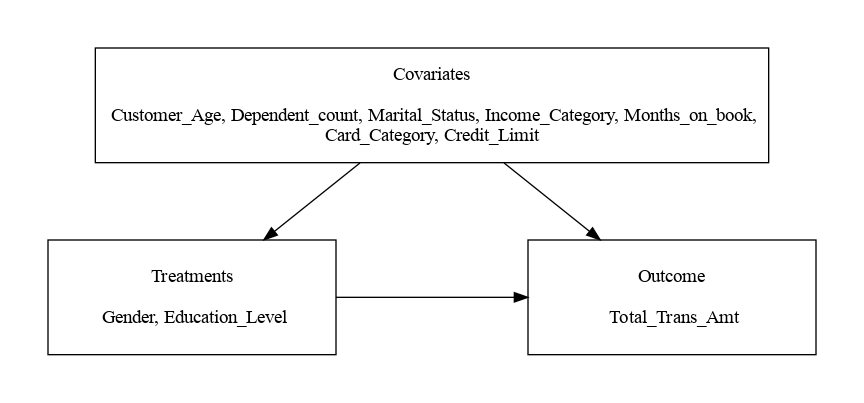

In [16]:
why.plot_causal_graph()

We observe customer gender and education level are identified as the important factors that impact the total transaction amounts. The two features are quite reasonable. However, it's hard to make them as treaments in practice. 

### B. Estimate causal effect on train_data

Just to show the method usage, we estimate the causal effects by taking 'M'(gender) and 'College'(education level) as treatments. 

In [17]:
why.causal_effect(control=['M','College'])

mean           min  \
Gender          F vs M                    406.626866 -16334.569379   
Education_Level Doctorate vs College      513.555777 -15261.128900   
                Graduate vs College       237.586831 -15306.590172   
                High School vs College    434.868307 -15409.586171   
                Post-Graduate vs College  366.174504 -15187.796393   
                Uneducated vs College     343.300940 -15311.588333   
                Unknown vs College        214.187185 -15124.595100   

                                                   max          std  
Gender          F vs M                    15510.584747  4813.098184  
Education_Level Doctorate vs College      14312.104970  4722.906472  
                Graduate vs College       16048.334966  4421.579541  
                High School vs College    16052.578128  4658.106673  
                Post-Graduate vs College  15567.004489  4640.986284  
                Uneducated vs College     15354.585566  4581.909083  
                Unknown vs College        15540.590368  4371.778955

### C. Estimate causal effect on test_data

The causal effect estimations of test_data are displayed. 

In [18]:
why.causal_effect(test_data, control=['M','College'])

mean           min  \
Gender          F vs M                    400.416773 -15499.642309   
Education_Level Doctorate vs College      661.178857 -14701.608489   
                Graduate vs College       237.804192 -15170.706202   
                High School vs College    489.521115 -15346.590508   
                Post-Graduate vs College  483.465416 -14834.954442   
                Uneducated vs College     303.299251 -15664.424730   
                Unknown vs College        256.288343 -15033.169526   

                                                   max          std  
Gender          F vs M                    15510.584747  4875.212986  
Education_Level Doctorate vs College      14319.936226  4822.661456  
                Graduate vs College       15999.538285  4449.147322  
                High School vs College    15310.397378  4720.221727  
                Post-Graduate vs College  15755.330659  4737.893396  
                Uneducated vs College     15119.889302  4701.585035  
                Unknown vs College        15593.935689  4390.361154

### D. Conclusion

Since gender and education level are attribute features, it's not practical to take them as treaments. This section introduces the uasge of causal discovery. Besides, the estimation results from train data and test data are quite similar, which reflects the robustness of the method.  